# Analysis Goal
load the data for NYC building data, flood zone data, building height, and property value data to analyze the building height and property value in NYC flood zones through linear regression.
The analysis will be visualized in bivariate choropleth map.

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
file = r"..\..\..\Data\original\nyc_building.geojson"
file2 = r"..\..\..\Data\original\nyc_flood_vulnerability.geojson"
file3 = r"..\..\..\Data\processed\cleaned_property_valuation.geojson"
nyc_building = gpd.read_file(file)
nyc_building_height = nyc_building[['height_roof', 'bin', 'geometry']]
nyc_flood_zone = gpd.read_file(file2)
nyc_flood_zone = nyc_flood_zone[['ss_cur', 'geometry']]
nyc_property = gpd.read_file(file3)

In [3]:
print(nyc_building_height.shape)
print(nyc_property.shape)
print(nyc_flood_zone.shape)

(1082838, 3)
(821255, 3)
(2209, 2)


In [9]:
print(nyc_building_height.columns)
print(nyc_flood_zone.columns)
print(nyc_property.columns)

Index(['height_roof', 'bin', 'geometry'], dtype='object')
Index(['ss_cur', 'geometry'], dtype='object')
Index(['bin', 'avg_fullval', 'geometry'], dtype='object')


In [12]:
nyc_building_height['height_roof'] = pd.to_numeric(nyc_building_height['height_roof'], errors='coerce')
nyc_flood_zone['ss_cur'] = pd.to_numeric(nyc_flood_zone['ss_cur'], errors='coerce')
nyc_building_height = nyc_building_height.dropna(subset=['height_roof'])
nyc_building_height['height_roof'] = nyc_building_height['height_roof'].astype(int)

In [21]:
nyc_property_no_geom = nyc_property.drop(columns='geometry')

building_height_property = nyc_building_height.merge(
    nyc_property_no_geom,
    on='bin',
    how='inner'
)

building_height_property.shape


(810520, 4)

In [14]:
building_height_property.shape
building_height_property.columns

Index(['height_roof', 'bin', 'geometry', 'avg_fullval'], dtype='object')

# ss_cur
the column is hurricane evacuation zone, 
1 = highest risk, evacuates first during hurricate
2-4 = medium to high risk zones
5 = lower risk, evacuated last

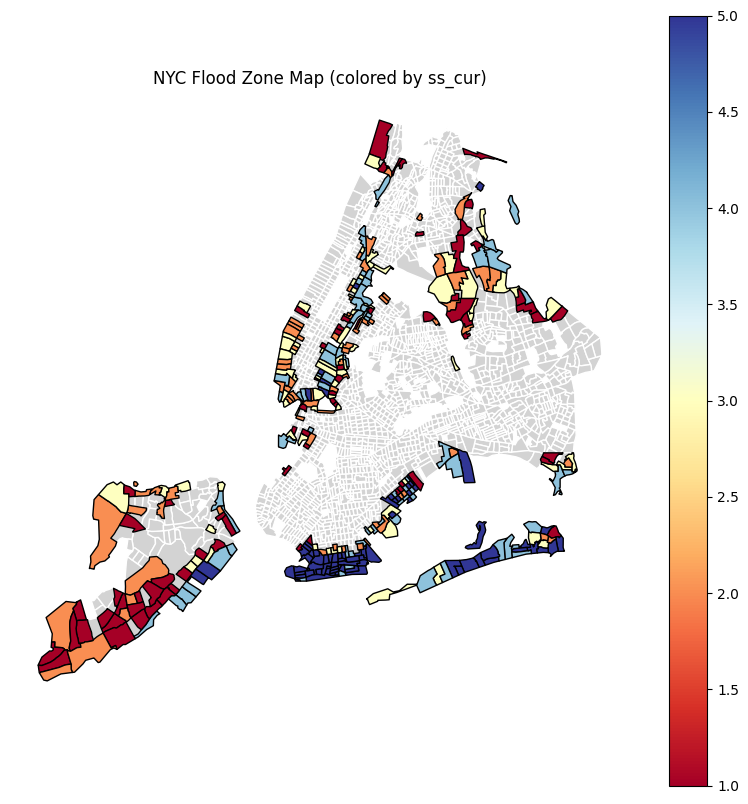

In [19]:
import matplotlib.pyplot as plt

has_flood_data = nyc_flood_zone['ss_cur'].notna()
fig, ax = plt.subplots(figsize=(10, 10))
nyc_flood_zone[~has_flood_data].plot(ax=ax, color='lightgrey', edgecolor='white')
nyc_flood_zone[has_flood_data].plot(ax=ax, column='ss_cur', cmap='RdYlBu', edgecolor='black', legend=True)

ax.set_axis_off()
plt.title("NYC Flood Zone Map (colored by ss_cur)")
plt.show()

In [22]:
flood_zone_polygons = nyc_flood_zone[nyc_flood_zone['ss_cur'].notna()]

if building_height_property.crs != flood_zone_polygons.crs:
    building_height_property = building_height_property.to_crs(flood_zone_polygons.crs)

buildings_in_floodzone = gpd.sjoin(
    building_height_property, 
    flood_zone_polygons[['ss_cur', 'geometry']], 
    how="inner", 
    predicate="intersects"
)

buildings_in_floodzone.columns

Index(['height_roof', 'bin', 'geometry', 'avg_fullval', 'index_right',
       'ss_cur'],
      dtype='object')

the dataframe is filtered from 810,520 rows to 167,522 rows.

# Linear regression

linear regression model is run for building height and property within the flood zone, the training is not for predicting the unknown data, but to find out the best fit line so that a general trend can be analyzed between property value and building height.
The analysis is not for the relationship between each property and its height, but for the entire building height and the average property value.

In [23]:
from sklearn.linear_model import LinearRegression
import numpy as np

df = buildings_in_floodzone.dropna(subset=['height_roof', 'avg_fullval'])

X = df[['height_roof']].values
y = df['avg_fullval'].values

model = LinearRegression()
model.fit(X, y)

print(f"Coefficient (slope): {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")
print(f"R-squared: {model.score(X, y):.4f}")

Coefficient (slope): 196843.36
Intercept: -4706242.37
R-squared: 0.1481


Prompt: these are the result. if you are the LLM for my project, how would you tell the user about this data? (eg: for every feet taller, the property value changes by blah blah)


🧠 LLM Response to User:
📊 "There is a positive correlation between building height and property value within NYC flood zones. Based on the data, 
for every additional 1 foot in building height, the average property value increases by approximately $196,843.

🔎 However, the relationship is moderately weak — the R² score is 0.15, meaning building height alone explains only about 15% of the variation in property value. 
Other factors likely contribute significantly to property value beyond just building height."

"A linear regression model shows that for each 1-foot increase in building height, the average property value rises by $196,843. However, the low R² value (0.1481) suggests that height alone is not a strong predictor and should be interpreted with caution"

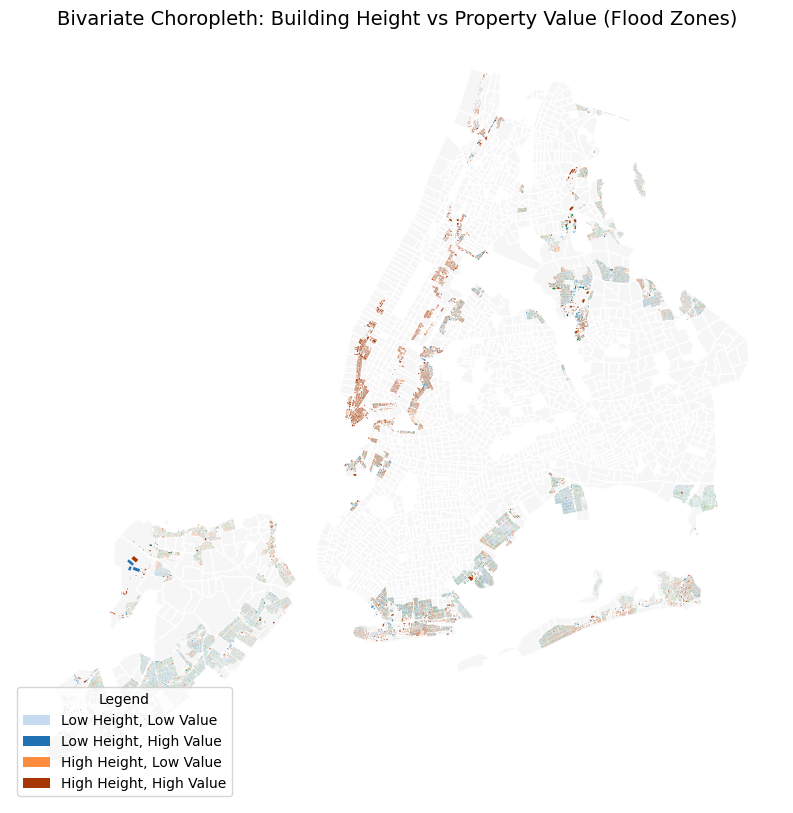

In [28]:
from matplotlib.patches import Patch

# 1. Create the base layer: all NYC flood zone geometries (light grey)
nyc_outline = nyc_flood_zone.copy()

# 2. Prepare filtered building dataset
df = buildings_in_floodzone.copy()
df = df.dropna(subset=['height_roof', 'avg_fullval'])

# Quantile classification into 3 bins
df['height_bin'] = pd.qcut(df['height_roof'], q=3, labels=[0, 1, 2])
df['value_bin'] = pd.qcut(df['avg_fullval'], q=3, labels=[0, 1, 2])
df['bivariate_class'] = df['height_bin'].astype(str) + df['value_bin'].astype(str)

# 3. Updated, more saturated bivariate colormap
bivariate_cmap = {
    '00': '#c6dbef',  # light blue
    '01': '#6baed6',  # medium blue
    '02': '#2171b5',  # dark blue
    '10': '#74c476',  # light green
    '11': '#31a354',  # medium green
    '12': '#006d2c',  # dark green
    '20': '#fd8d3c',  # light orange
    '21': '#e6550d',  # medium orange
    '22': '#a63603',  # dark orange
}
df['color'] = df['bivariate_class'].map(bivariate_cmap)

# 4. Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot background NYC shape in light grey
nyc_outline.plot(ax=ax, color="#f6f6f6", edgecolor='white')

# Plot buildings with bivariate color
df.plot(ax=ax, color=df['color'], markersize=5)

# Formatting
ax.set_axis_off()
plt.title("Bivariate Choropleth: Building Height vs Property Value (Flood Zones)", fontsize=14)

# 5. Legend for selected corners
legend_elements = [
    Patch(facecolor=bivariate_cmap['00'], label='Low Height, Low Value'),
    Patch(facecolor=bivariate_cmap['02'], label='Low Height, High Value'),
    Patch(facecolor=bivariate_cmap['20'], label='High Height, Low Value'),
    Patch(facecolor=bivariate_cmap['22'], label='High Height, High Value'),
]
ax.legend(handles=legend_elements, loc='lower left', title="Legend", fontsize=10)

plt.show()

🧠 LLM Response (Enhanced, Region-Based Insight):
📍 The map illustrates how the relationship between building height and property value varies across NYC's flood-prone regions.

🗽 Lower Manhattan
- Dominated by low-rise, high-value buildings (blue), especially in historic or luxury zones near the waterfront.
- This suggests property value is driven more by location than height in this area — possibly due to prestige, zoning restrictions, or architectural heritage.

🧱 Southern Brooklyn & Staten Island
- Large clusters of low-rise, low-value buildings (light grey/blue).
- Here, both height and property value are low, suggesting less vertical development and lower real estate pressure in flood-prone suburban zones.

🏢 Long Island City & Western Queens
- Notable presence of high-rise, low-value buildings (orange), particularly near newer waterfront developments.
- This may indicate vertical development precedes property appreciation, or flood risk may be suppressing value despite building height.

🧬 Downtown Brooklyn & parts of the Bronx
- Mixture of high-rise, high-value buildings (dark brown) and low-rise, high-value ones.
- These areas exhibit a stronger positive correlation between height and property value, possibly reflecting growing urban density and market-driven high-rise construction.

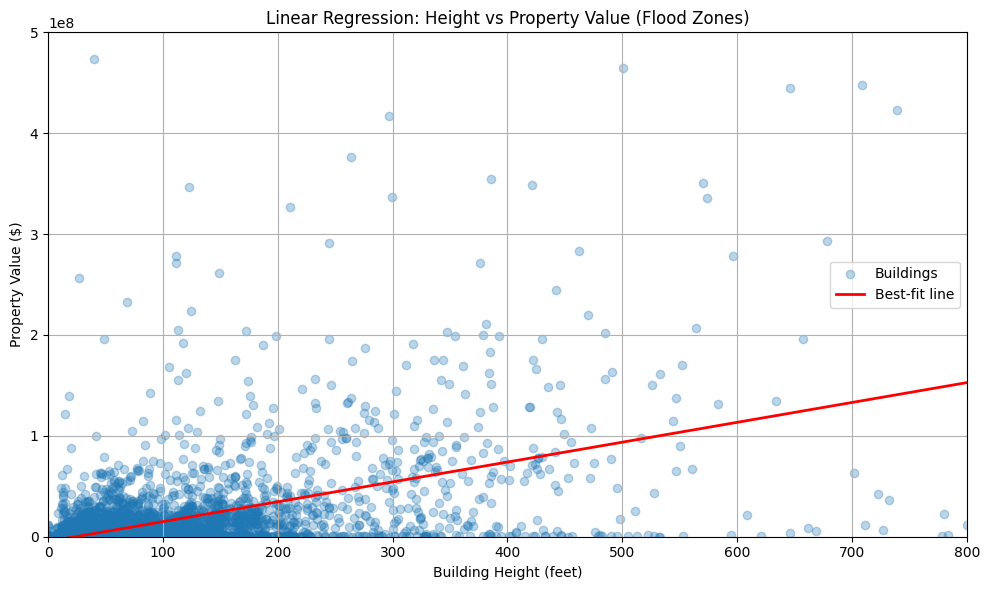

In [35]:
# 1. Prepare the data (drop missing values)
df = buildings_in_floodzone.dropna(subset=['height_roof', 'avg_fullval'])

X = df[['height_roof']].values
y = df['avg_fullval'].values

# 2. Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# 3. Predict values for plotting the regression line
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# 4. Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.3, label='Buildings')
plt.plot(x_range, y_pred, color='red', linewidth=2, label='Best-fit line')

plt.xlim(0, 800)
plt.ylim(0, 500000000)

plt.xlabel('Building Height (feet)')
plt.ylabel('Property Value ($)')
plt.title('Linear Regression: Height vs Property Value (Flood Zones)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()